In [1]:
import prunable_layers

In [2]:
import os
import numpy
import pandas
import seaborn
import tensorflow
from datetime import datetime
from matplotlib import pyplot
from tensorflow import losses, metrics
from tensorflow.keras import layers, models, utils, preprocessing, activations, optimizers, callbacks

In [3]:
#Tries to enable dynamic memory allocation on GP
try:
    for i in tensorflow.config.experimental.list_physical_devices("GPU"):
        tensorflow.config.experimental.set_memory_growth(i, True)
except:
    print("Device dynamic memory allocation failed!")

In [4]:
seaborn.set_style("darkgrid")

In [5]:
df_train = pandas.read_csv("train.tsv", sep='\t')
print("train set: {0}".format(df_train.shape))
df_train.head(10)

train set: (156060, 4)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


In [6]:
df_test = pandas.read_csv('test.tsv', sep='\t')
print('test set: {0}'.format(df_test.shape))
df_test.head(10)

test set: (66292, 3)


,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine
5,156066,8545,intermittently pleasing but
6,156067,8545,intermittently pleasing
7,156068,8545,intermittently
8,156069,8545,pleasing
9,156070,8545,but


In [7]:
replace_list = {r"i'm": 'i am', r"'re": ' are', r"let’s": 'let us', r"'s":  ' is', r"'ve": ' have', r"can't": 'can not', r"cannot": 'can not', r"shan’t": 'shall not', r"n't": ' not',
                r"'d": ' would', r"'ll": ' will', r"'scuse": 'excuse', ',': ' ,', '.': ' .', '!': ' !', '?': ' ?', '\s+': ' '}

In [8]:
def clean_text(text):
    text = text.lower()
    for s in replace_list:
        text = text.replace(s, replace_list[s])
    text = ' '.join(text.split())
    return text

In [9]:
X_train = df_train["Phrase"].apply(lambda p: clean_text(p))
X_test = df_test["Phrase"].apply(lambda p: clean_text(p))

In [10]:
phrase_len = X_train.apply(lambda p: len(p.split(' ')))
max_phrase_len = phrase_len.max()
print('max phrase len: {0}'.format(max_phrase_len))

max phrase len: 53


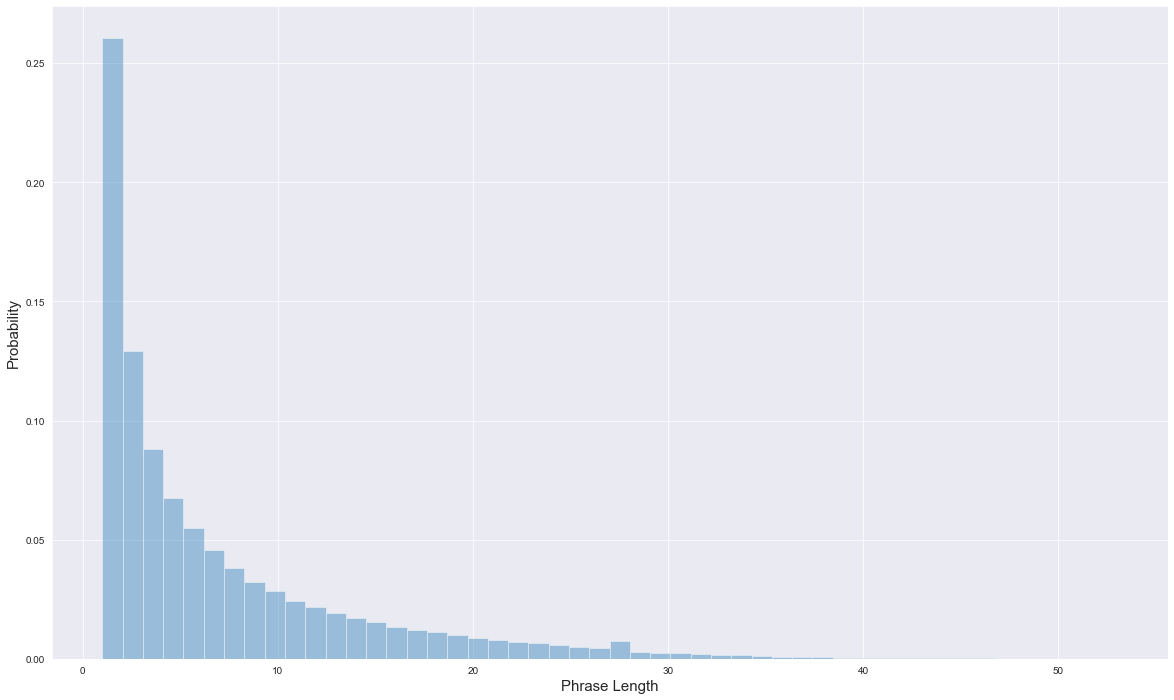

In [11]:
_, axis = pyplot.subplots(figsize=(20, 12))
seaborn.distplot(phrase_len, kde=False, norm_hist=True)
axis.set_ylabel("Probability", fontsize=15)
axis.set_xlabel("Phrase Length", fontsize=15)
pyplot.show()

In [12]:
y_train = df_train['Sentiment']

In [13]:
max_words = 8192
tokenizer = preprocessing.text.Tokenizer(num_words=max_words, filters='"#$%&()*+-/:;<=>@[\]^_`{|}~')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train = preprocessing.sequence.pad_sequences(X_train, maxlen=max_phrase_len)
y_train = utils.to_categorical(y_train)

In [14]:
u = numpy.unique(y_train, return_counts=True, axis=0)

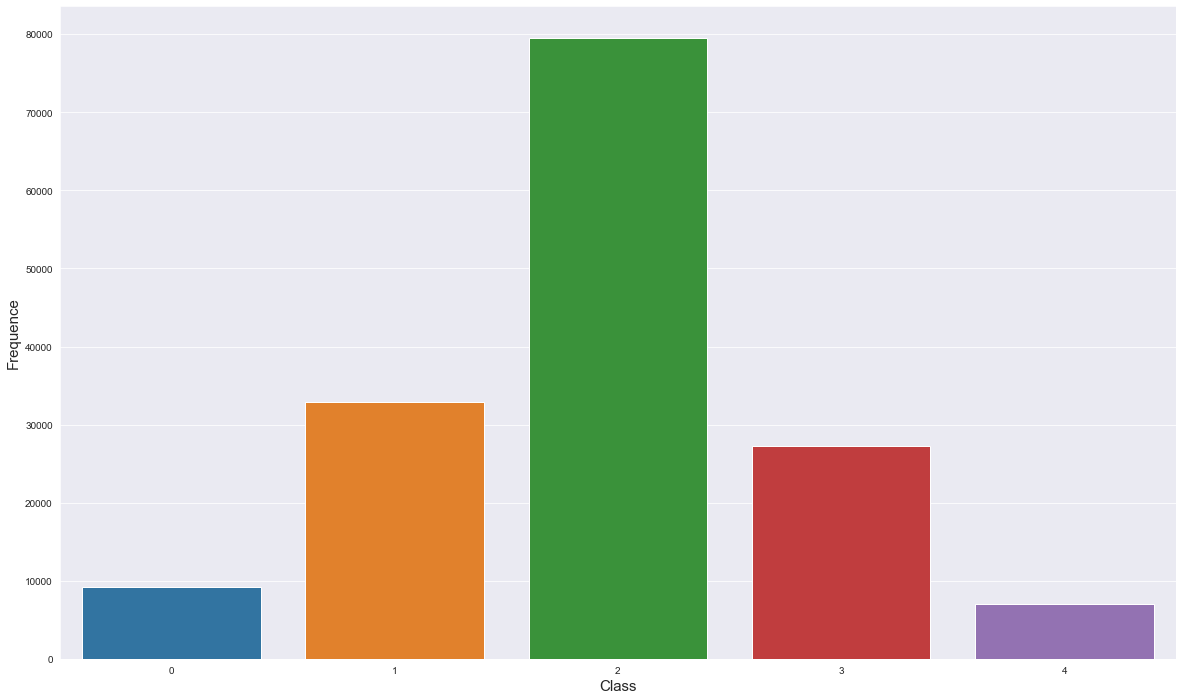

In [15]:
_, axis = pyplot.subplots(figsize=(20, 12))
seaborn.barplot(x=[i for i in range(u[0].shape[0])], y=u[1])
axis.set_ylabel("Frequence", fontsize=15)
axis.set_xlabel("Class", fontsize=15)
pyplot.show()

In [16]:
test_phrase_len = X_test.apply(lambda p: len(p.split(' ')))
test_max_phrase_len = test_phrase_len.max()

In [17]:
max_words = 8192
tokenizer = preprocessing.text.Tokenizer(num_words=max_words, filters='"#$%&()*+-/:;<=>@[\]^_`{|}~')
tokenizer.fit_on_texts(X_test)
X_test = tokenizer.texts_to_sequences(X_test)
X_test = preprocessing.sequence.pad_sequences(X_test, maxlen=max_phrase_len)

In [18]:
metrics_list = [metrics.CategoricalAccuracy(), metrics.Precision(), metrics.Recall(), metrics.AUC()]
model_lstm = models.Sequential()
model_lstm.add(layers.Embedding(input_dim=max_words, output_dim=256, input_length=max_phrase_len))
model_lstm.add(prunable_layers.PrunableLSTM(256, activation=activations.tanh))
model_lstm.add(prunable_layers.PrunableDense(256, activation=activations.relu))
model_lstm.add(prunable_layers.PrunableDense(128, activation=activations.relu))
model_lstm.add(prunable_layers.PrunableDense(64, activation=activations.relu))
model_lstm.add(prunable_layers.PrunableDense(32, activation=activations.relu))
model_lstm.add(prunable_layers.PrunableDense(5, activation=activations.softmax))
model_lstm.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.Adam(learning_rate=0.001), metrics=metrics_list)
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 53, 256)           2097152   
_________________________________________________________________
prunable_lstm (PrunableLSTM) (None, 256)               525312    
_________________________________________________________________
prunable_dense (PrunableDens (None, 256)               65792     
_________________________________________________________________
prunable_dense_1 (PrunableDe (None, 128)               32896     
_________________________________________________________________
prunable_dense_2 (PrunableDe (None, 64)                8256      
_________________________________________________________________
prunable_dense_3 (PrunableDe (None, 32)                2080      
_________________________________________________________________
prunable_dense_4 (PrunableDe (None, 5)                 1

In [19]:
for layer in model_lstm.layers:
    if isinstance(layer, layers.RNN):
        layer.cell.save_kernel()
        layer.cell.save_recurrent_kernel()
        layer.cell.save_bias()
    elif isinstance(layer, layers.Dense):
        layer.save_kernel()
        layer.save_bias()

In [20]:
!rm -rf ./.logs/

In [21]:
logdir = os.path.join(".logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = callbacks.TensorBoard(log_dir=logdir, histogram_freq=1, embeddings_freq=1)

In [22]:
history_lstm = model_lstm.fit(X_train, y_train, epochs=10, batch_size=2048, validation_data=(X_train, y_train), callbacks=[tensorboard_callback])

Train on 156060 samples, validate on 156060 samples
Epoch 1/10
156060/156060 [==============================] - 105s 675us/sample - loss: 1.2065 - categorical_accuracy: 0.5159 - precision: 0.6785 - recall: 0.3476 - auc: 0.8052 - val_loss: 1.0821 - val_categorical_accuracy: 0.5574 - val_precision: 0.7214 - val_recall: 0.4165 - val_auc: 0.8439
Epoch 2/10
156060/156060 [==============================] - 118s 754us/sample - loss: 1.0097 - categorical_accuracy: 0.5922 - precision: 0.7253 - recall: 0.4422 - auc: 0.8677 - val_loss: 0.8563 - val_categorical_accuracy: 0.6538 - val_precision: 0.7186 - val_recall: 0.5560 - val_auc: 0.9060
Epoch 3/10
156060/156060 [==============================] - 115s 736us/sample - loss: 0.8362 - categorical_accuracy: 0.6625 - precision: 0.7111 - recall: 0.5795 - auc: 0.9097 - val_loss: 0.7715 - val_categorical_accuracy: 0.6895 - val_precision: 0.7308 - val_recall: 0.6170 - val_auc: 0.9227
Epoch 4/10
156060/156060 [==============================] - 115s 738us/s

In [23]:
%load_ext tensorboard

In [25]:
%tensorboard --logdir .logs

Reusing TensorBoard on port 6006 (pid 18800), started 2:16:02 ago. (Use '!kill 18800' to kill it.)

In [26]:
y = model_lstm.predict_classes(X_test)

In [27]:
u = numpy.unique(y, return_counts=True)

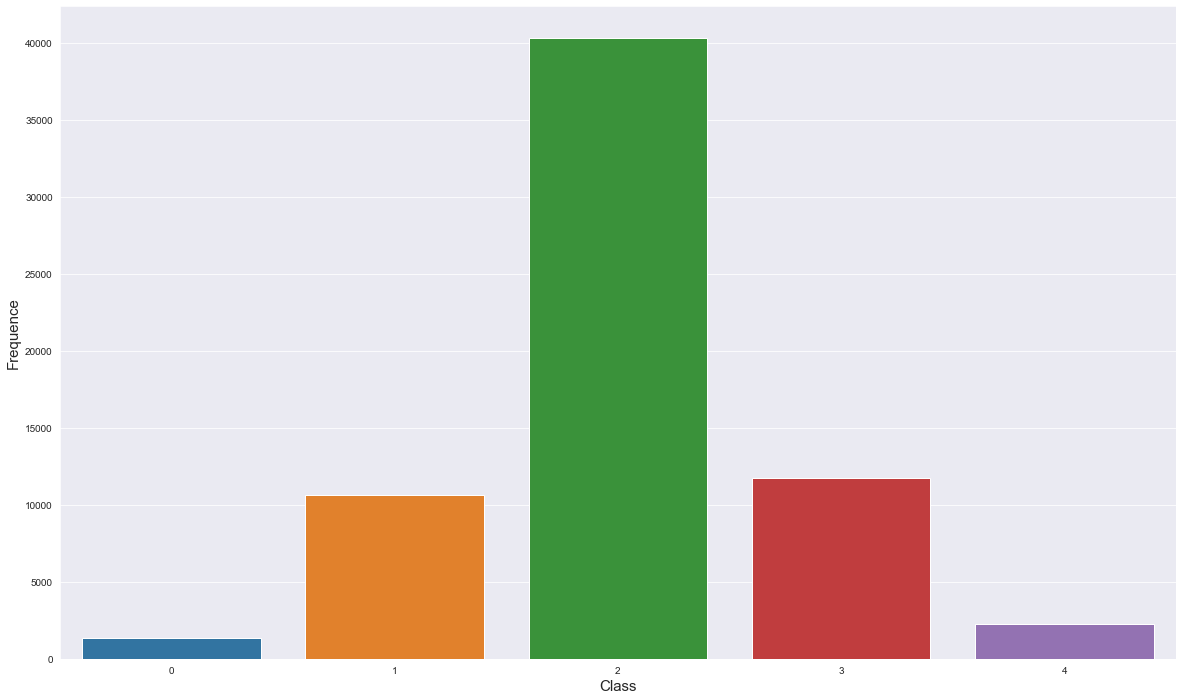

In [28]:
_, axis = pyplot.subplots(figsize=(20, 12))
seaborn.barplot(x=u[0], y=u[1])
axis.set_ylabel("Frequence", fontsize=15)
axis.set_xlabel("Class", fontsize=15)
pyplot.show()

In [29]:
l = []
for layer in model_lstm.layers:
    if isinstance(layer, layers.RNN):
        l.append(tensorflow.reshape(layer.cell.kernel, (-1,))[tensorflow.reshape(layer.cell.trainable_channels, (-1,)) == 1])
        l.append(tensorflow.reshape(layer.cell.recurrent_kernel, (-1,))[tensorflow.reshape(layer.cell.trainable_recurrent_channels, (-1,)) == 1])
        l.append(tensorflow.reshape(layer.cell.bias, (-1,))[tensorflow.reshape(layer.cell.trainable_bias, (-1,)) == 1])
    elif isinstance(layer, layers.Dense):
        l.append(tensorflow.reshape(layer.kernel, (-1,))[tensorflow.reshape(layer.trainable_channels, (-1,)) == 1])
        l.append(tensorflow.reshape(layer.bias, (-1,))[tensorflow.reshape(layer.trainable_bias, (-1,)) == 1])

In [30]:
s = tensorflow.sort(tensorflow.concat(l, axis=-1))
p = int(numpy.floor((7. / 10.) * len(s)))
threshold = s[p].numpy()

In [31]:
for layer in model_lstm.layers:
    if isinstance(layer, layers.RNN):
        indices_kernel = tensorflow.where(layer.cell.kernel < threshold)
        indices_bias = tensorflow.where(layer.cell.bias < threshold)
        indices_recurrent = tensorflow.where(layer.cell.recurrent_kernel < threshold)
        t1 = tensorflow.tensor_scatter_nd_update(tensorflow.ones(layer.cell.kernel.shape), indices_kernel, tensorflow.zeros(len(indices_kernel)))
        t2 = tensorflow.tensor_scatter_nd_update(tensorflow.ones(layer.cell.recurrent_kernel.shape), indices_recurrent, tensorflow.zeros(len(indices_recurrent)))
        t3 = tensorflow.tensor_scatter_nd_update(tensorflow.ones(layer.cell.bias.shape), indices_bias, tensorflow.zeros(len(indices_bias)))
        layer.cell.prune_kernel(t1)
        layer.cell.prune_recurrent_kernel(t2)
        layer.cell.prune_bias(t3)
    elif isinstance(layer, layers.Dense):
        indices_kernel = tensorflow.where(layer.kernel < threshold)
        indices_bias = tensorflow.where(layer.bias < threshold)
        t1 = tensorflow.tensor_scatter_nd_update(tensorflow.ones(layer.kernel.shape), indices_kernel, tensorflow.zeros(len(indices_kernel)))
        t2 = tensorflow.tensor_scatter_nd_update(tensorflow.ones(layer.bias.shape), indices_bias, tensorflow.zeros(len(indices_bias)))
        layer.prune_kernel(t1)
        layer.prune_bias(t2)

In [34]:
!rm -rf ./.logs/

In [35]:
for layer in model_lstm.layers:
    if isinstance(layer, layers.RNN):
        layer.cell.restore_kernel()
        layer.cell.restore_recurrent_kernel()
        layer.cell.restore_bias()
    elif isinstance(layer, layers.Dense):
        layer.restore_kernel()
        layer.restore_bias()

In [36]:
history_lstm = model_lstm.fit(X_train, y_train, epochs=10, batch_size=2048, validation_data=(X_train, y_train), callbacks=[tensorboard_callback])

Train on 156060 samples, validate on 156060 samples
Epoch 1/10
156060/156060 [==============================] - 39s 253us/sample - loss: 1.0431 - categorical_accuracy: 0.5859 - precision: 0.6940 - recall: 0.4233 - auc: 0.8599 - val_loss: 0.7421 - val_categorical_accuracy: 0.6942 - val_precision: 0.7289 - val_recall: 0.6326 - val_auc: 0.9280
Epoch 2/10
156060/156060 [==============================] - 40s 259us/sample - loss: 0.7080 - categorical_accuracy: 0.7087 - precision: 0.7381 - recall: 0.6600 - auc: 0.9337 - val_loss: 0.6427 - val_categorical_accuracy: 0.7341 - val_precision: 0.7601 - val_recall: 0.6938 - val_auc: 0.9448
Epoch 3/10
156060/156060 [==============================] - 41s 260us/sample - loss: 0.6588 - categorical_accuracy: 0.7256 - precision: 0.7495 - recall: 0.6865 - auc: 0.9418 - val_loss: 0.6224 - val_categorical_accuracy: 0.7437 - val_precision: 0.7698 - val_recall: 0.6990 - val_auc: 0.9480
Epoch 4/10
156060/156060 [==============================] - 42s 267us/sampl

In [37]:
%tensorboard --logdir .logs

Reusing TensorBoard on port 6006 (pid 18800), started 2:28:14 ago. (Use '!kill 18800' to kill it.)

In [38]:
y = model_lstm.predict_classes(X_test)

In [39]:
u = numpy.unique(y, return_counts=True)

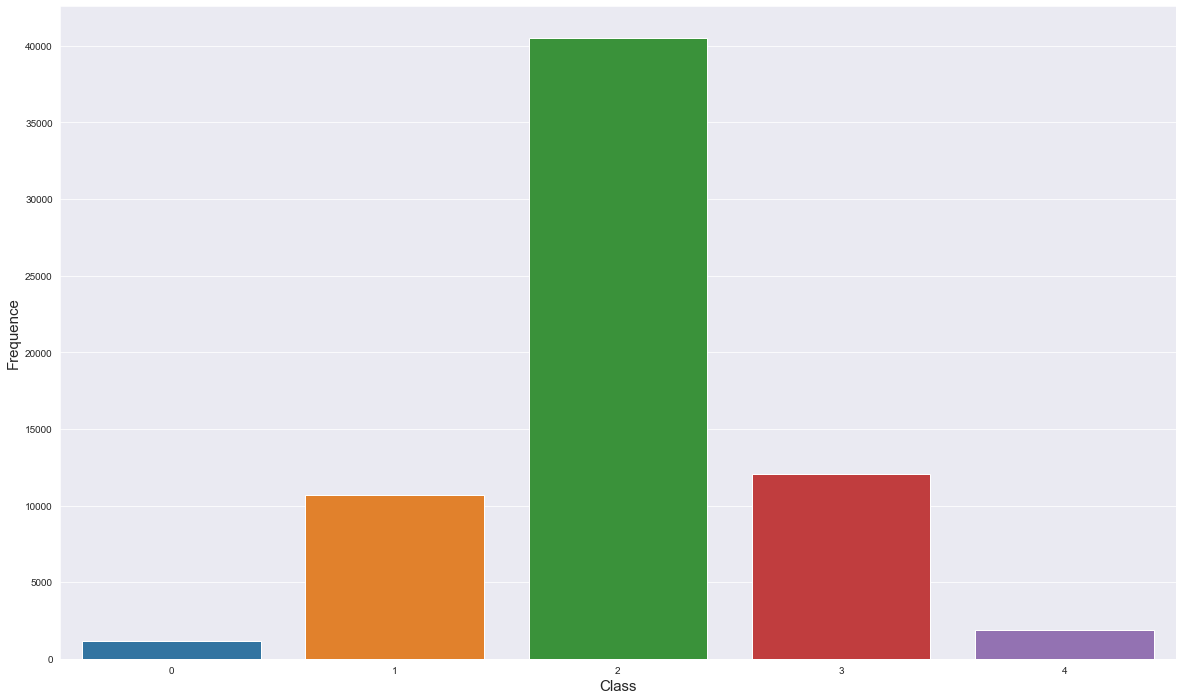

In [40]:
_, axis = pyplot.subplots(figsize=(20, 12))
seaborn.barplot(x=u[0], y=u[1])
axis.set_ylabel("Frequence", fontsize=15)
axis.set_xlabel("Class", fontsize=15)
pyplot.show()

In [32]:
metrics_list = [metrics.CategoricalAccuracy(), metrics.Precision(), metrics.Recall(), metrics.AUC()]
model_gru = models.Sequential()
model_gru.add(layers.Embedding(input_dim=max_words, output_dim=256, input_length=max_phrase_len))
model_gru.add(prunable_layers.PrunableGRU(256, activation=activations.tanh))
model_gru.add(prunable_layers.PrunableDense(256, activation=activations.relu))
model_gru.add(prunable_layers.PrunableDense(128, activation=activations.relu))
model_gru.add(prunable_layers.PrunableDense(64, activation=activations.relu))
model_gru.add(prunable_layers.PrunableDense(32, activation=activations.relu))
model_gru.add(prunable_layers.PrunableDense(5, activation=activations.softmax))
model_gru.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.Adam(learning_rate=0.001), metrics=metrics_list)
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 53, 256)           2097152   
_________________________________________________________________
prunable_gru_1 (PrunableGRU) (None, 256)               394752    
_________________________________________________________________
prunable_dense_10 (PrunableD (None, 256)               65792     
_________________________________________________________________
prunable_dense_11 (PrunableD (None, 128)               32896     
_________________________________________________________________
prunable_dense_12 (PrunableD (None, 64)                8256      
_________________________________________________________________
prunable_dense_13 (PrunableD (None, 32)                2080      
_________________________________________________________________
prunable_dense_14 (PrunableD (None, 5)                

In [33]:
!rm -rf ./logs/

In [34]:
logdir = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

In [35]:
history = model_gru.fit(X_train, y_train, epochs=10, batch_size=2048, validation_data=(X_train, y_train), callbacks=[tensorboard_callback])

Train on 156060 samples, validate on 156060 samples
Epoch 1/10
156060/156060 [==============================] - 122s 780us/sample - loss: 1.1881 - categorical_accuracy: 0.5242 - precision_1: 0.6875 - recall_1: 0.3450 - auc_1: 0.8109 - val_loss: 1.0299 - val_categorical_accuracy: 0.5797 - val_precision_1: 0.7248 - val_recall_1: 0.4414 - val_auc_1: 0.8619
Epoch 2/10
156060/156060 [==============================] - 117s 747us/sample - loss: 0.9072 - categorical_accuracy: 0.6344 - precision_1: 0.7079 - recall_1: 0.5199 - auc_1: 0.8943 - val_loss: 0.8049 - val_categorical_accuracy: 0.6736 - val_precision_1: 0.7232 - val_recall_1: 0.5866 - val_auc_1: 0.9161
Epoch 3/10
156060/156060 [==============================] - 121s 776us/sample - loss: 0.8052 - categorical_accuracy: 0.6738 - precision_1: 0.7166 - recall_1: 0.6000 - auc_1: 0.9159 - val_loss: 0.7515 - val_categorical_accuracy: 0.6964 - val_precision_1: 0.7399 - val_recall_1: 0.6190 - val_auc_1: 0.9266
Epoch 4/10
156060/156060 [==========

In [37]:
%reload_ext tensorboard

In [39]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 10140), started 1 day, 16:47:23 ago. (Use '!kill 10140' to kill it.)

In [40]:
y = model_gru.predict_classes(X_test)

In [41]:
u = numpy.unique(y, return_counts=True)

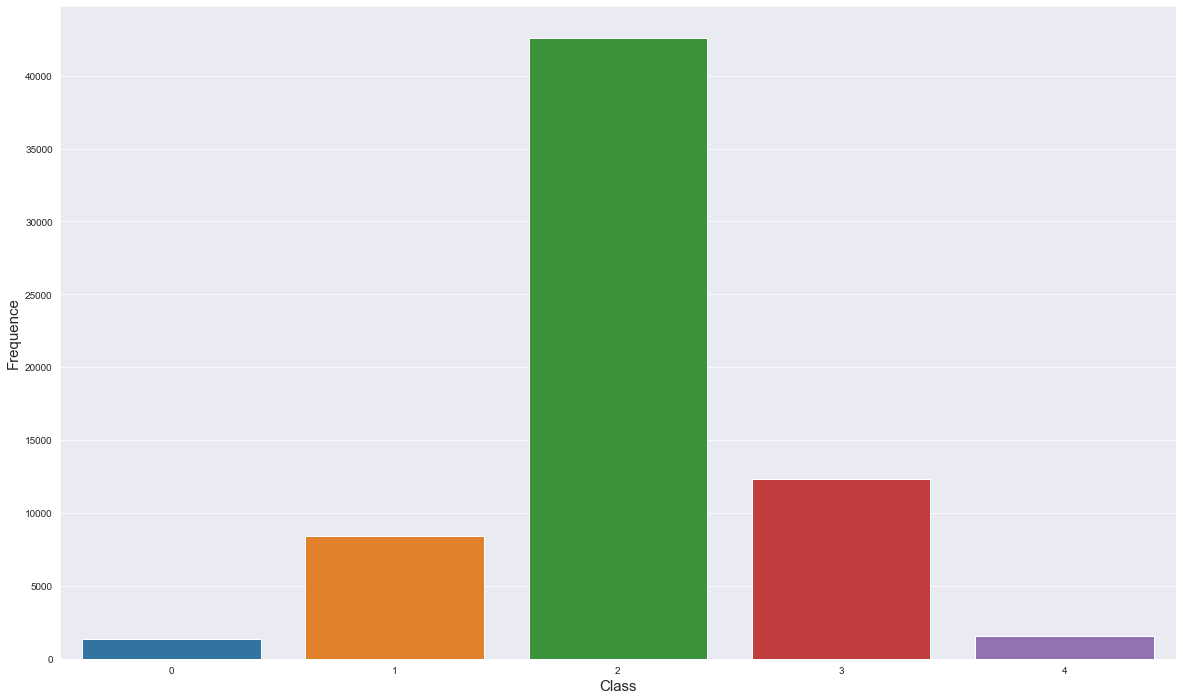

In [42]:
_, axis = pyplot.subplots(figsize=(20, 12))
seaborn.barplot(x=u[0], y=u[1])
axis.set_ylabel("Frequence", fontsize=15)
axis.set_xlabel("Class", fontsize=15)
pyplot.show()